In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import LMC
import imp
import astropy.stats
import scipy.signal as sig
import scipy.optimize as op
import dcor

from scipy import stats

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric
from sklearn.datasets  import make_blobs
from sklearn.datasets  import make_circles

from timeit import default_timer

pi = np.pi

# Make synthetic data, test with k-means and spectral clustering

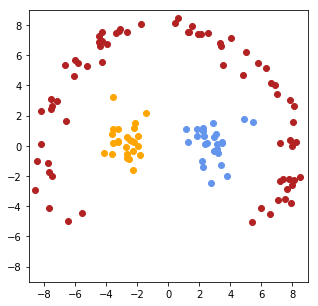

In [2]:
# make blobs
blobs  = make_blobs(n_features=2, n_samples=50, centers=np.array([[3,0],[-3,0]]))
xb, yb = blobs[0][:,0], blobs[0][:,1]

# make an arc
theta = np.random.uniform(0,2*pi,100)

theta = theta[theta < 3*pi/2] - pi/4
xa    = 8*np.cos(theta) + 0.5*np.random.randn(len(theta))
ya    = 8*np.sin(theta) + 0.5*np.random.randn(len(theta))

# combine data
x = np.hstack([xb,xa])
y = np.hstack([yb,ya])

data = np.array([x,y]).swapaxes(0,1)

ground_truth = np.squeeze(np.hstack([blobs[1], 2*np.ones_like(xa)]))
colors = ['cornflowerblue', 'orange', 'firebrick', 'mediumblue', 'navy']


plt.figure(figsize=(5,5))
for i in range(3):
    plt.plot(x[ground_truth==i], y[ground_truth==i], 'o', color=colors[i])
    plt.xlim(-9,9)
    plt.ylim(-9,9)
plt.show()

# Manually calculate the similarity matrix

In [3]:
def make_similarity_matrix(data, sigma):
    eucDM = DistanceMetric.get_metric('euclidean')
    xij   = eucDM.pairwise(data)
    sij   = np.exp(-xij**2/(2*sigma**2)) - np.eye(len(data))
    
    return sij

In [4]:
# initial similarity matrix
sij = make_similarity_matrix(data, sigma=1.0)

n_nodes = sij.shape[0]

print(n_nodes, 'nodes')

121 nodes


# Find paths using Depth First Search (DFS)

In [5]:
class Graph:
    def __init__(self, similarity_matrix, adjacency_matrix, best_edge_matrix):
        self.S = similarity_matrix
        self.A = adjacency_matrix
        self.B = best_edge_matrix       # should use an upper triangle matrix
        
        self.n_nodes = self.A.shape[0]
        self.index   = np.arange(self.n_nodes)

    
    def pathHelper(self, u, d, visited, path, mpl):
        # mark current node (u) as visited and store it in path
        visited[u] = True
        path.append(u)
        
        # if current node (u) is the destination (d), update best edge strength
        if u == d:
            # get the stength of all edges in the path
            path_edges  = np.ones(len(path)-1)
            for i in range(len(path)-1):
                path_edges[i] = self.S[path[i],path[i+1]]

            # track the strongest edge
            self.best_edge = path_edges.min()

         
        # otherwise, recurse for all adjacent nodes (a)
        elif len(path) <= mpl:
            adj_nodes = self.index[self.A[u]]
            
            # only search down paths that improve over the best edge strength found so far
            for a in adj_nodes:
                if (visited[a] == False):
                    if self.S[u,a] > self.best_edge:
                        self.pathHelper(a, d, visited, path, mpl)
                    else:
                        self.A[u,a] = False
            
        # remove current node from path and mark it as unvisited
        path.pop()
        visited[u] = False
        
        
    def findPaths(self, s, d, mpl):
        # mark all vertices as not visited
        visited = [False]*self.n_nodes
        
        # create a list to store paths
        path = []
        
        # call recursive helper function
        self.pathHelper(s, d, visited, path, mpl)

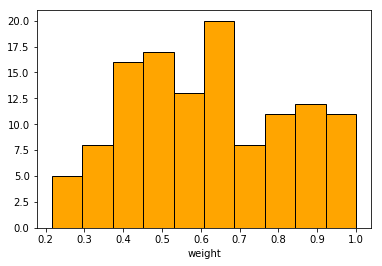

In [6]:
# calculate weights for each neighborhood
sij_eps = np.median(sij[sij!=0])

w = np.zeros(n_nodes)

for i in range(n_nodes):
    w[i] = np.sqrt(np.sum(sij[i][sij[i] > sij_eps]))
    
w /= w.max()

plt.figure()
plt.hist(w, color='orange', edgecolor='k')
plt.xlabel('weight')
plt.show()

checking paths (cycle 1, max_path_length = 2)


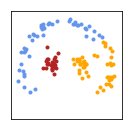


RUNTIME = 0.07

checking paths (cycle 2, max_path_length = 4)


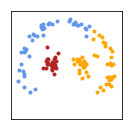


RUNTIME = 0.15

checking paths (cycle 3, max_path_length = 8)


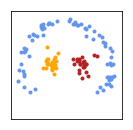


RUNTIME = 0.35

checking paths (cycle 4, max_path_length = 16)


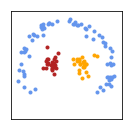


RUNTIME = 0.60

checking paths (cycle 5, max_path_length = 32)


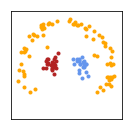


RUNTIME = 0.86

checking paths (cycle 6, max_path_length = 64)


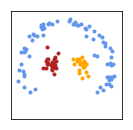


RUNTIME = 1.11

checking paths (cycle 7, max_path_length = 128)


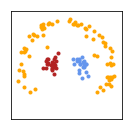


RUNTIME = 1.35


TOTAL RUNTIME = 1.35



In [7]:
# set maximum path length to search
max_path_length = 2


# initialize the graph
new_sij = np.outer(w,w)*sij
new_aij = new_sij > 0.0
new_bij = np.triu(new_sij)

g = Graph(new_sij, new_aij, new_bij)


# start timer
start_time = default_timer()


# now iteratively find paths through the graph
cycle = 0
while max_path_length**cycle < n_nodes:
    cycle += 1
    print('checking paths (cycle %d, max_path_length = %d)' %(cycle, max_path_length**cycle))
    
    # use DFS to find paths through the graph
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            g.best_edge = g.B[i,j]              # track strongest edge
            g.A *= (g.S >= g.best_edge)         # zero out any edges weaker than this (in adjacency matrix)
            g.findPaths(i, j, max_path_length)  # search for paths through the graph
            g.A = new_aij.copy()                # reset the adjacency matrix
            g.B[i,j] = g.best_edge.copy()       # store the best edge strength found
    
    # update graph
    new_sij = (g.B + g.B.T)
    new_aij = new_sij > 0.0
    new_bij = np.triu(new_sij.copy())
    
    g = Graph(new_sij, new_aij, new_bij)
    
    # run clustering on this new matrix
    sc = SpectralClustering(n_clusters=3, affinity='precomputed')
    scfit = sc.fit_predict(new_sij)

    plt.figure(figsize=(2,2))
    for i in range(3):
        plt.plot(x[scfit==i], y[scfit==i], '.', color=colors[i])
        plt.xlim(-10,10)
        plt.ylim(-10,10)
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
    print('\nRUNTIME = %.2f\n' %((default_timer()-start_time)/60))

    

end_time = default_timer()

print('\nTOTAL RUNTIME = %.2f\n' %((end_time-start_time)/60))


# Do eigenvector analysis

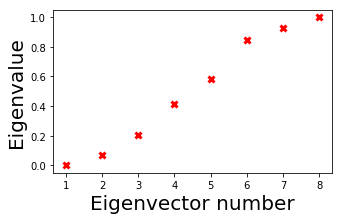

In [8]:
# construct graph laplacian
A = new_sij.copy()
W = A * (1 - np.eye(n_nodes))
D = np.diag(W.sum(axis=1))
L = D - W

# normalize (symmetric method)
D12   = np.linalg.inv(np.sqrt(D))
Lnorm = np.dot(np.dot(D12,L),D12)

# get eigenvectors & eigenvalues
lam, v = np.linalg.eig(Lnorm)

order = np.argsort(lam)
lam = lam[order]
v   = v[:,order]

plt.figure(figsize=(5,3))
plt.plot(1+np.arange(8), lam[:8]/np.max(lam[:8]), 'x', c='red', mew=3)
plt.xlabel('Eigenvector number', fontsize=20)
plt.ylabel('Eigenvalue', fontsize=20)
plt.show()

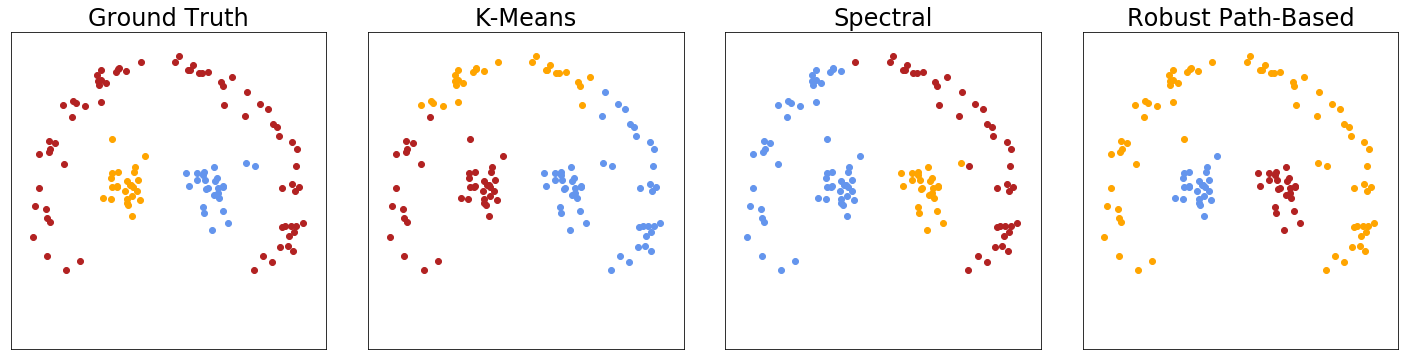

In [9]:
n_clusters = 3

# kmeans clustering
km = KMeans(n_clusters=n_clusters)
kmfit = km.fit_predict(data)

# standard spectral clustering
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
scfit = sc.fit_predict(data)

# robust path-based clustering
pb = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
pbfit = pb.fit_predict(new_sij)


fits   = [ground_truth, kmfit, scfit, pbfit]
titles = ['Ground Truth', 'K-Means', 'Spectral', 'Robust Path-Based']

fig, axes = plt.subplots(1,4, figsize=(20,5))
plt.tight_layout()


for i in range(4):
    ax = axes[i]
    for j in range(n_clusters):
        ax.plot(x[fits[i]==j], y[fits[i]==j], 'o', color=colors[j])
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=24)
    
#plt.savefig('/Users/research/Desktop/clustering_methods.pdf', bbox_inches='tight')
plt.show()